# **Moladin Case Study**

Ediashta Revindra

---

## Project Overview

### Background
Moladin provides capital for agents to buy used cars and in return Moladin charges fees (admin fee & aging fee) to agents when the cars are successfully sold. Every car buyout proposal by an agent has to be approved by the branch manager. In order to make an informed decision, the branch manager has to consider several parameters.

## Project Task
As a data scientis we are going to analyze the reason on why some care are selling below target, and create a model to help prevent and mitigate other poor quality buy happen in the future.
There are several steps that will be taken in this project:

1. Analyze the given datasets to gain insight on car buyout quality
2. Perform a regression modeling to predict the car sale price

For the modeling we are going to use 4 base model, which is:
1. Linear Regression
2. Decision Tree
3. Random Forest
4. XGBoost

From these 4 model we are going to choose the best one based on the **MAE** metrics to then perform parameter tuning

## 00. Import Libraries

In [312]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set_palette("coolwarm")


## 01. Data Loading

In [313]:
#import dataset
df = pd.read_csv('./case_study_data.csv')

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8023 entries, 0 to 8022
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_id        8023 non-null   int64  
 1   license_plate     8023 non-null   int64  
 2   car_year          8023 non-null   int64  
 3   car_brand         8023 non-null   object 
 4   car_model         8023 non-null   object 
 5   car_type          8023 non-null   object 
 6   car_transmission  8023 non-null   object 
 7   car_engine_size   8023 non-null   float64
 8   car_color         8023 non-null   object 
 9   inspection_score  8023 non-null   int64  
 10  agent_id          8016 non-null   float64
 11  branch_id         8023 non-null   int64  
 12  buy_date          8023 non-null   object 
 13  buy_price         8023 non-null   float64
 14  admin_fee         8023 non-null   float64
 15  aging_fee         8023 non-null   float64
 16  sell_date         8023 non-null   object 


In [315]:
num_col = df.select_dtypes(include=np.number).columns.tolist()
cat_col = df.select_dtypes(include=object).columns.tolist()

In [316]:
df.head()

,product_id,license_plate,car_year,car_brand,car_model,car_type,car_transmission,car_engine_size,car_color,inspection_score,agent_id,branch_id,buy_date,buy_price,admin_fee,aging_fee,sell_date,sell_price
0,133126,265,2015,TOYOTA,ALL NEW AVANZA VELOZ,VVT-I,MT,1.5,Hitam,102,109618.0,289,2022-08-09,15788.0,266.0,0.0,2022-08-16,16053.0
1,134207,2396,2007,HONDA,NEW CR-V,4 X 2,AT,2.4,Hitam,103,53630.0,94,2022-08-15,11375.0,250.0,312.0,2022-09-18,11938.0
2,127971,4926,2015,SUZUKI,KARIMUN WAGON R,GL,MT,1.0,Silver,107,18827.0,397,2022-08-20,6288.0,250.0,0.0,2022-08-20,6538.0
3,126434,678,2014,DAIHATSU,AYLA,M SPORTY,MT,1.0,Hitam,107,19174.0,93,2022-07-28,9412.0,250.0,0.0,2022-07-30,9662.0
4,128325,1908,2017,SUZUKI,NEW ERTIGA,GX,MT,1.4,Putih,107,28462.0,19,2022-08-14,15375.0,250.0,0.0,2022-08-14,15625.0


In [317]:
df.duplicated().sum()

0

There is no duplicated data, this mean all rows are completely unique

In [318]:
df.isna().sum()

product_id          0
license_plate       0
car_year            0
car_brand           0
car_model           0
car_type            0
car_transmission    0
car_engine_size     0
car_color           0
inspection_score    0
agent_id            7
branch_id           0
buy_date            0
buy_price           0
admin_fee           0
aging_fee           0
sell_date           0
sell_price          0
dtype: int64

There is 7 missing data found, we are going to check the type of missing data

In [319]:
df[df['agent_id'].isna()]

,product_id,license_plate,car_year,car_brand,car_model,car_type,car_transmission,car_engine_size,car_color,inspection_score,agent_id,branch_id,buy_date,buy_price,admin_fee,aging_fee,sell_date,sell_price
468,127311,5539,2017,TOYOTA,AGYA,G 1.2 TRD SPORTIVO,AT,1.2,Putih,106,NaN,71,2022-07-26,13750.0,250.0,188.0,2022-08-16,14125.0
557,136416,6326,2012,DAIHATSU,ALL NEW XENIA,M SPORTY,MT,1.0,Putih,105,NaN,68,2022-08-09,10625.0,250.0,188.0,2022-09-01,11062.0
1768,138448,643,2004,NISSAN,XTRAIL,ST,AT,2.5,ABU ABU METALIK,107,NaN,36,2022-08-19,7500.0,250.0,0.0,2022-08-19,7750.0
2715,139176,1317,2009,TOYOTA,AVANZA,G,MT,1.3,SILVER METALLIC,107,NaN,36,2022-08-24,10625.0,250.0,0.0,2022-08-24,10875.0
7323,132700,1340,2009,DAIHATSU,TERIOS,TX,AT,1.5,Hitam,107,NaN,289,2022-08-23,11875.0,250.0,0.0,2022-09-01,12125.0
7954,139491,644,1997,ISUZU,PANTHER,TBR54 STD,MT,2.5,ABU ABU METALIK,107,NaN,36,2022-08-21,5625.0,250.0,0.0,2022-08-21,5875.0
7981,135750,4581,2011,TOYOTA,AVANZA,G,MT,1.3,Hitam,107,NaN,36,2022-08-23,11875.0,250.0,312.0,2022-09-25,12438.0


There doesn't seem any correlation from the missing data with other columns, so we can categorized this as Missing Completely at Random, and can further drop these rows considering the little amount

In [320]:
df.dropna(inplace=True)

From the dataframe info above we can see that the date is in object format, so we are going to convert it into datetime

In [321]:
#change type to datetime
df['buy_date'] = df['buy_date'].astype('datetime64[ns]')
df['sell_date'] = df['sell_date'].astype('datetime64[ns]')

df[['buy_date', 'sell_date']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 8016 entries, 0 to 8022
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   buy_date   8016 non-null   datetime64[ns]
 1   sell_date  8016 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 187.9 KB


## 02.EDA

We have the information that 
$$ TargetPrice = BuyPrice + AdminPrice + AgingFee $$
so we are going to add a new column based on these formula to help us gain insight on car buyout

In [322]:
#count target_price

target_prices = []
for index, row in df.iterrows():
    target_price = row['buy_price'] + row['admin_fee'] + row['aging_fee']
    target_prices.append(target_price)

df['target_price'] = target_prices

In [323]:
df.describe()

,product_id,license_plate,car_year,car_engine_size,inspection_score,agent_id,branch_id,buy_date,buy_price,admin_fee,aging_fee,sell_date,sell_price,target_price
count,8016.000000,8016.000000,8016.000000,8016.000000,8016.000000,8016.000000,8016.000000,8016,8016.000000,8016.000000,8016.000000,8016,8016.000000,8016.000000
mean,135421.963074,4262.771956,2011.818239,1.563822,105.323478,66780.767590,173.372380,2022-08-20 11:11:08.263473152,12636.912051,269.396332,49.577844,2022-08-28 07:17:47.065868288,12903.661677,12955.886228
min,10143.000000,1.000000,1975.000000,1.000000,29.000000,930.000000,1.000000,2022-07-23 00:00:00,438.000000,250.000000,0.000000,2022-07-24 00:00:00,688.000000,688.000000
25%,133051.500000,2146.750000,2009.000000,1.300000,107.000000,17622.000000,57.000000,2022-08-12 18:00:00,8750.000000,250.000000,0.000000,2022-08-17 00:00:00,9000.000000,9000.000000
50%,136326.500000,4272.500000,2013.000000,1.500000,107.000000,60934.500000,126.000000,2022-08-20 00:00:00,11875.000000,250.000000,0.000000,2022-08-26 00:00:00,12125.000000,12125.000000
75%,139452.750000,6377.250000,2016.000000,1.500000,107.000000,116900.250000,302.000000,2022-08-29 00:00:00,15000.000000,250.000000,0.000000,2022-09-06 00:00:00,15250.000000,15250.000000
max,143505.000000,8490.000000,2022.000000,13.000000,107.000000,153464.000000,416.000000,2022-09-15 00:00:00,112500.000000,1469.000000,812.000000,2022-10-31 00:00:00,114031.000000,114031.000000
std,5597.720262,2453.503321,6.290872,0.567065,5.890223,49627.069491,134.126344,NaN,6843.487212,65.685004,117.932412,NaN,6908.757195,6925.855406


We found out that several sell price are lower than the target price, this might indicate the poor quality buyout, we are going to investigate it further

<Axes: xlabel='buy_price', ylabel='target_price'>

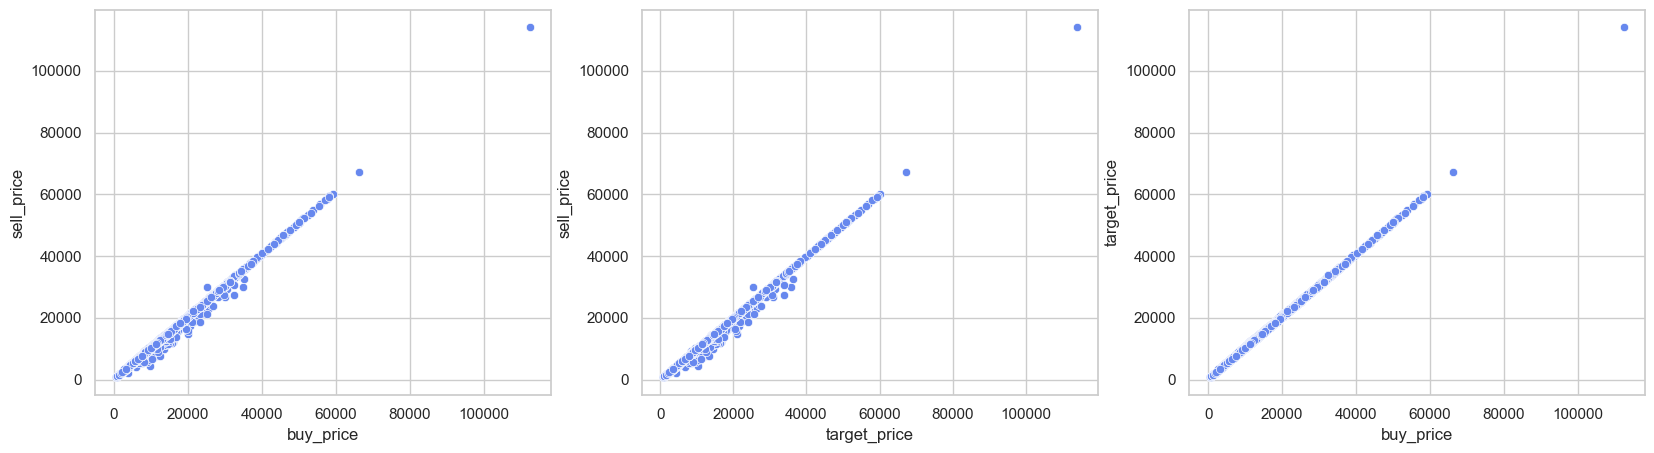

In [324]:
fig, axes = plt.subplots(1,3, figsize=(20,5))

sns.scatterplot(data=df, x='buy_price', y='sell_price', ax=axes[0])
sns.scatterplot(data=df, x='target_price', y='sell_price', ax=axes[1])
sns.scatterplot(data=df, x='buy_price', y='target_price', ax=axes[2])

Judging from the scatter plot above, all prices should be linear, but as we can see there are several car with slight difference in sell_price and target_price

We need to check the basic statistics of this differences

In [325]:
#check revenue differences
revenue_diff = []
for index, row in df.iterrows():
    revenue = row['sell_price'] - row['target_price']
    revenue_diff.append(revenue)

df['revenue_diff'] = revenue_diff
pd.DataFrame(df['revenue_diff'].describe())

,revenue_diff
count,8016.000000
mean,-52.224551
std,403.426149
min,-6281.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,4656.000000


We found out that we have mean of sell price difference at around -52, this means that we loss more from the car sales rather than gaining revenue

On the other hands, there are cars that loss 6281 and cars that sells 4656 more than the target prices, we are going to investigate the loss revenue

in this case, we are gonna assume that maximum tolerable revenue loss is 10 percent of target prices, so the car that sells 10% lower than targeted price will be categorized as not fullfiling target (0)

*note that this10% is still an assumption and more data are needed to support this hypothesis*


In [326]:
#create a mark for data that is below target

sell_label =[]
for index, row in df.iterrows():
    difference = row['sell_price'] - row['target_price']
    percentage = (difference/row['sell_price'])*100
    
    if percentage < -10:
        label = 0 #below target
    else:
        label = 1 #above target
    
    sell_label.append(label)

df['isTarget'] = sell_label

Text(0.5, 1.0, 'Count of isTarget Categories')

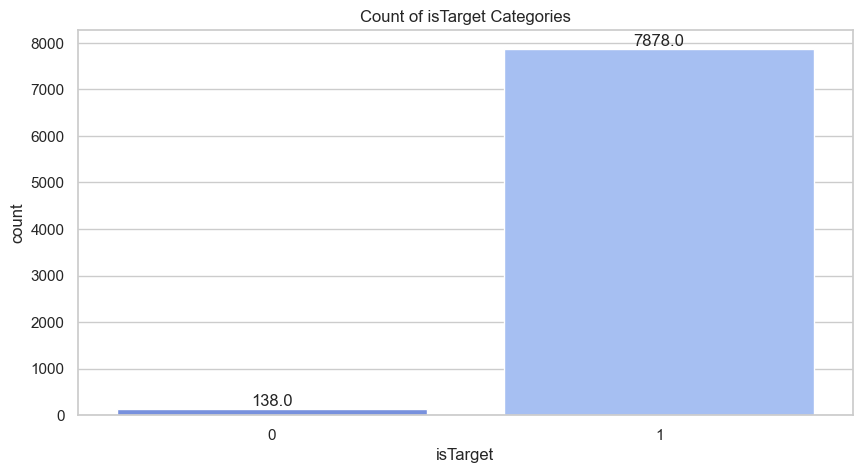

In [327]:
plt.figure(figsize=(10,5))

ax = sns.countplot(data=df, x='isTarget')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

# Add a title to the plot
plt.title('Count of isTarget Categories')

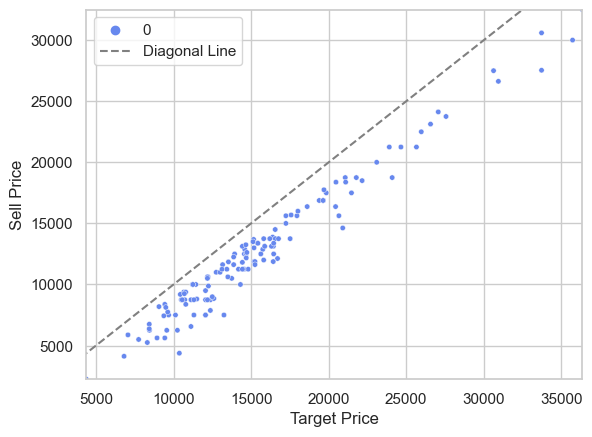

In [328]:
#filter dataframe to display
filtered_df = df[df['isTarget'] == 0]

#add scatterplot
sns.scatterplot(data=filtered_df, x='target_price', y='sell_price', hue='isTarget', s=15)

#add a diagonal line
sns.lineplot(x=[df['target_price'].min(), df['target_price'].max()],
             y=[df['target_price'].min(), df['target_price'].max()],
             color='gray', linestyle='--', label='Diagonal Line')

#add labels and legend
plt.xlabel('Target Price')
plt.ylabel('Sell Price')
plt.legend()

#set axis limits to only show the scatterplot
plt.xlim(filtered_df['target_price'].min(), filtered_df['target_price'].max())
plt.ylim(filtered_df['sell_price'].min(), filtered_df['sell_price'].max())

# Show the plot
plt.show()

We can see from the scatterplot that the revenue loss is vary for each car, we are going to observe the correlation from other columns on what makes the car sell below the target

In [329]:
#encode categorical to later plot into a correlation heatmap
df_corr = df.copy()
for col in df_corr[cat_col]:
    le = LabelEncoder()
    df_corr[col] = le.fit_transform(df_corr[col])

df_corr.drop(columns=['product_id', 'license_plate'])
df_corr.head()

,product_id,license_plate,car_year,car_brand,car_model,car_type,car_transmission,car_engine_size,car_color,inspection_score,...,branch_id,buy_date,buy_price,admin_fee,aging_fee,sell_date,sell_price,target_price,revenue_diff,isTarget
0,133126,265,2015,6,6,820,1,1.5,57,102,...,289,17,15788.0,266.0,0.0,23,16053.0,16054.0,-1.0,1
1,134207,2396,2007,1,186,48,0,2.4,57,103,...,94,23,11375.0,250.0,312.0,56,11938.0,11937.0,1.0,1
2,127971,4926,2015,5,138,341,1,1.0,99,107,...,397,28,6288.0,250.0,0.0,27,6538.0,6538.0,0.0,1
3,126434,678,2014,0,38,480,1,1.0,57,107,...,93,5,9412.0,250.0,0.0,6,9662.0,9662.0,0.0,1
4,128325,1908,2017,5,189,368,1,1.4,92,107,...,19,22,15375.0,250.0,0.0,21,15625.0,15625.0,0.0,1


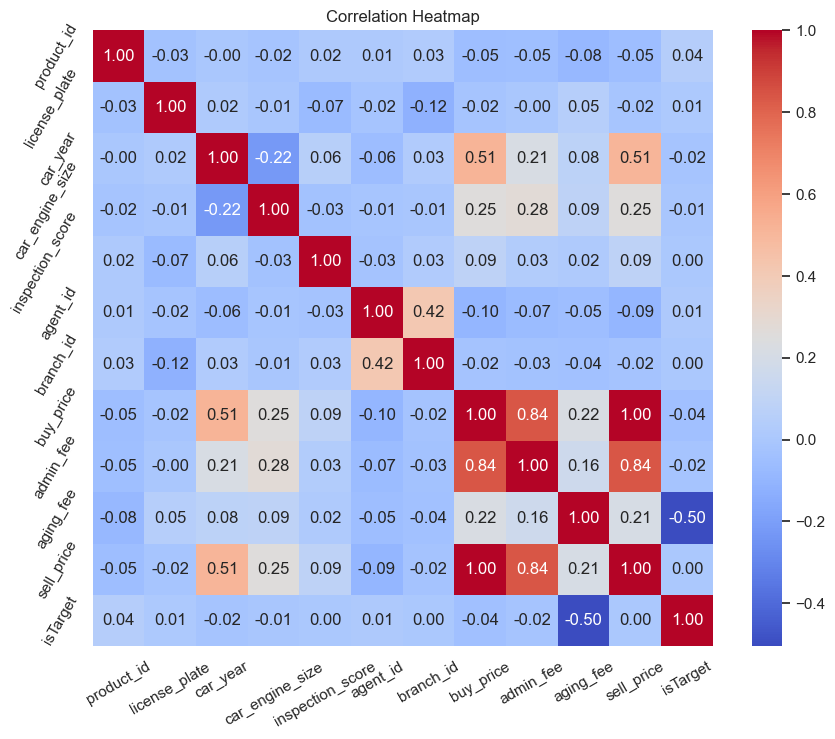

In [330]:
#create a correlation for each columns
loss_corr_matrix = df[num_col + ['isTarget']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))  # Set the figure size (optional)

# Create the heatmap with annotated values
sns.heatmap(loss_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Rotate x-axis tick labels by 30 degrees
plt.xticks(rotation=30)

# Rotate y-axis tick labels by 60 degrees
plt.yticks(rotation=60)

# Add a title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

From the numerical columns. we gain insight that there are several columns that have positive correlation with sell price such as:
* Car Year
* Car Engine Size
* Buy Price
* Admin Fee
* Aging Fee
* Sell Price

This mean that as these column value get higher, the car sell price will also get higher

As for the correlation with fulfilling the target, there are only aging fee that has a high correlation with negative value, this might indicate that the higher the aging fee, the more likely the car is not going to sell at the target price, we are going to inspect this aspect further

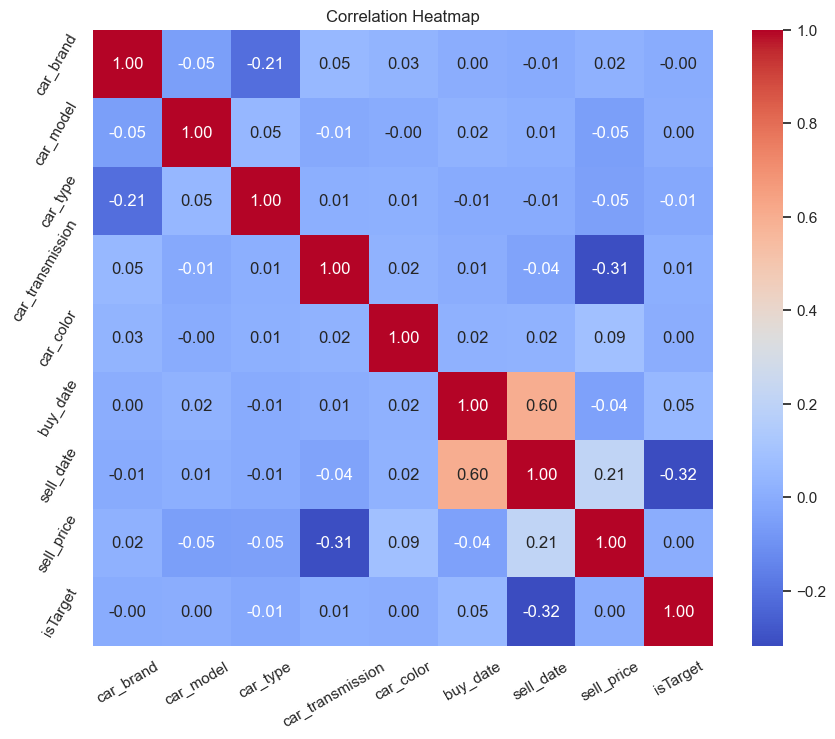

In [331]:
#create a correlation for each columns
loss_corr_matrix = df_corr[cat_col + ['sell_price', 'isTarget']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))  # Set the figure size (optional)

# Create the heatmap with annotated values
sns.heatmap(loss_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Rotate x-axis tick labels by 30 degrees
plt.xticks(rotation=30)

# Rotate y-axis tick labels by 60 degrees
plt.yticks(rotation=60)

# Add a title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

As for the categorical column, only the car transmission and sell date have high correlation with sell price

But, we can see that the sell date have high correlation with target and buy date, this might affect the aging fee stated above

Text(0.5, 0.98, 'Aging Fee')

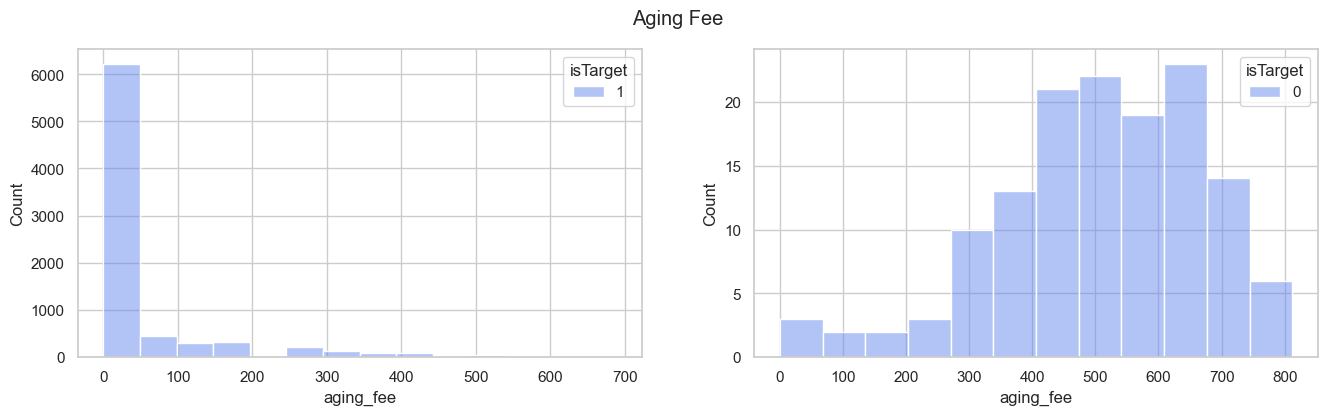

In [372]:
fig, axes = plt.subplots(1,2, figsize=(16,4))
sns.histplot(data=df[df['isTarget']==1], x='aging_fee', hue='isTarget', ax=axes[0])
sns.histplot(data=filtered_df, x='aging_fee', hue='isTarget', ax=axes[1])

plt.suptitle('Aging Fee')

From the histogram above, it looks like confirming our speculation before that higher aging fee tend to not achieve the target price. 

So with the aging fee playing a factor in car sales, we gonna check the distribution of the days car stored in inventory

In [333]:
date_diff = []
for index, row in df.iterrows():
    diff = (row['sell_date'] - row['buy_date'])
    date_diff.append(diff)

df['date_diff'] = date_diff
df['date_diff'] = df['date_diff'].dt.days

df[['buy_date', 'sell_date', 'date_diff']].head()

,buy_date,sell_date,date_diff
0,2022-08-09,2022-08-16,7
1,2022-08-15,2022-09-18,34
2,2022-08-20,2022-08-20,0
3,2022-07-28,2022-07-30,2
4,2022-08-14,2022-08-14,0


Text(0.5, 0.98, 'Date Difference')

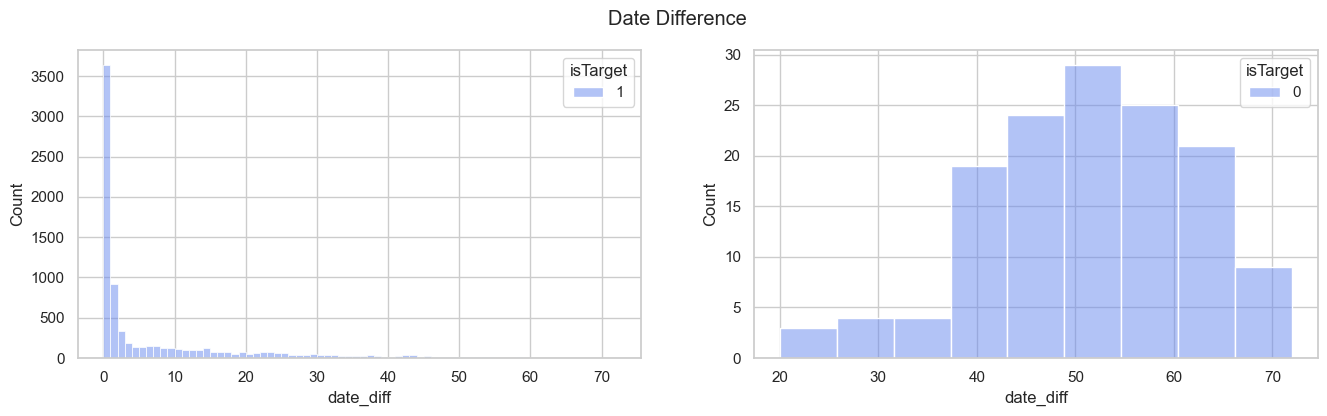

In [375]:
fig, axes = plt.subplots(1,2, figsize=(16,4))
sns.histplot(data=df[df['isTarget']==1], x='date_diff', hue='isTarget', ax=axes[0])
sns.histplot(data=df[df['isTarget']==0], x='date_diff', hue='isTarget', ax=axes[1])
plt.suptitle('Date Difference')


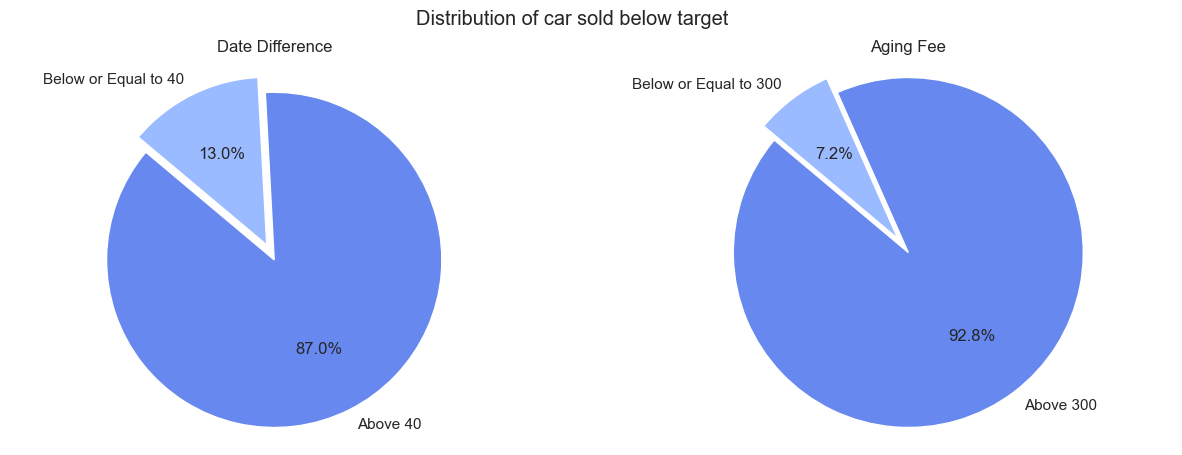

In [335]:
date_above = len(df[df['date_diff'] > 40][df['isTarget']==0])
date_below = len(df[df['date_diff'] <= 40][df['isTarget']==0])
fee_above = len(df[df['aging_fee'] > 300][df['isTarget']==0])
fee_below = len(df[df['aging_fee'] <= 300][df['isTarget']==0])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Create a pie chart
labels = ['Above 40', 'Below or Equal to 40']
sizes = [date_above, date_below]
explode = (0.1, 0)

axes[0].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)
axes[0].axis('equal')
axes[0].set_title('Date Difference')

labels = ['Above 300', 'Below or Equal to 300']
sizes = [fee_above, fee_below]
explode = (0.1, 0)

axes[1].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)
axes[1].axis('equal')
axes[1].set_title('Aging Fee')

plt.suptitle('Distribution of car sold below target')
plt.show()

There are more than 80% of cars that is sold below target have 40 days date stored, and 92% have aging fee above 300, this means that the difference between buy and sell date are correlated with the aging fee, so with more time the car stored at the warehouse, it is more likely to be sold below the target price

## 03. Feature Engineering

### Feature Selection

In [336]:
df_selected = df[['car_year','car_engine_size', 'car_transmission', 'buy_price', 'admin_fee', 'aging_fee','sell_price', 'date_diff']]

In [337]:
num_col_selected = df_selected.select_dtypes(include=np.number).columns.tolist()
num_col_selected.remove('sell_price')
cat_col_selectd = df_selected.select_dtypes(include=object).columns.tolist()

num_col_selected, cat_col_selectd

(['car_year',
  'car_engine_size',
  'buy_price',
  'admin_fee',
  'aging_fee',
  'date_diff'],
 ['car_transmission'])

### Split Train Test

In [338]:
X = df_selected.drop(columns='sell_price')
y = df_selected["sell_price"]

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

### Outliers Handling

In [340]:
#boxplot function
def box_plot(column, loc, row, axs):
    ax = sns.boxplot(data=df_selected, x=column, ax=axs[loc,row], fliersize=3, boxprops=dict(alpha=.7))
    ax.set_title(column, fontsize=15)
    ax.set(xlabel=None)

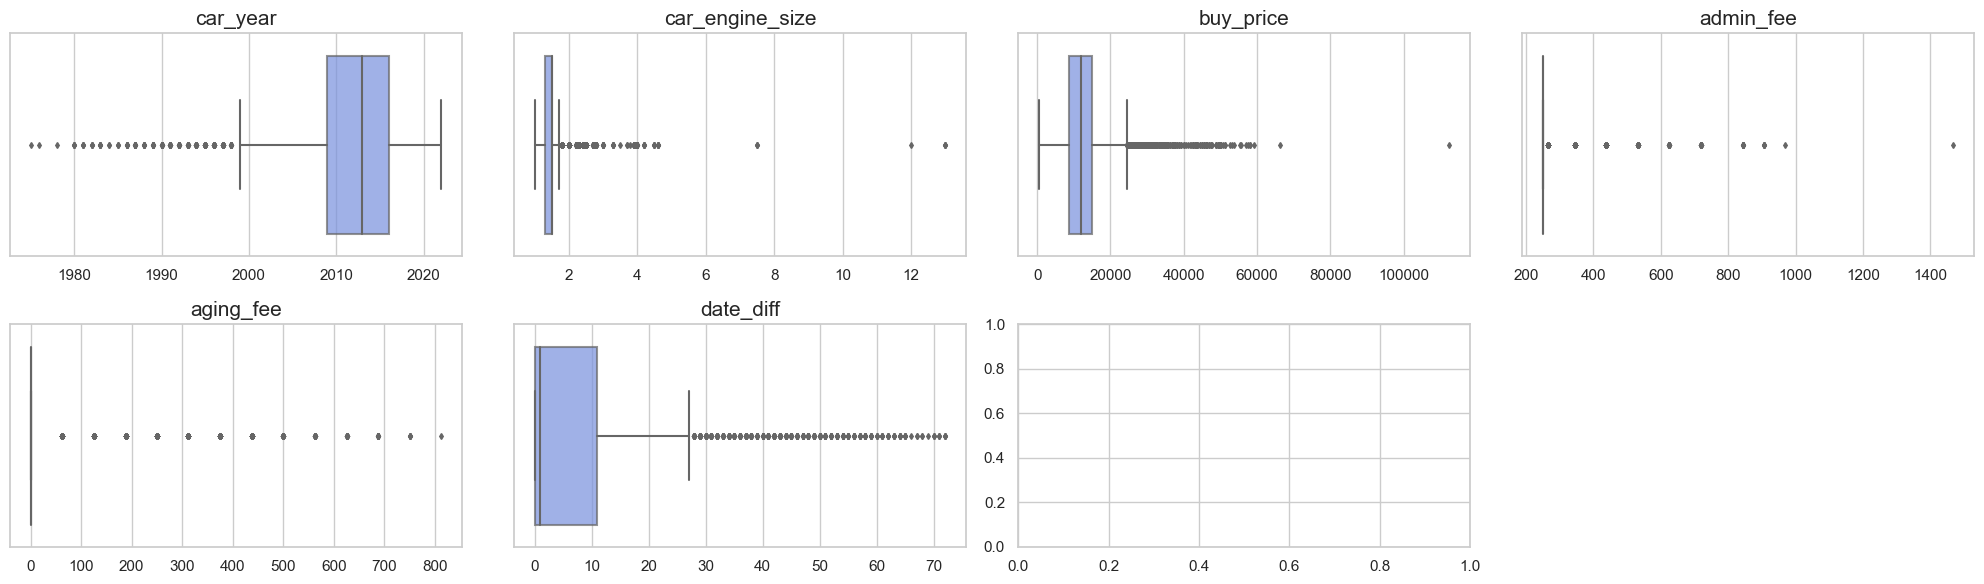

In [341]:
#loop boxplot
fig, axs = plt.subplots(2,4, figsize=(20,6))
for i,x in enumerate(num_col_selected):
    if i < 4:
        box_plot(x, 0, i, axs)
    elif i < 8:
        box_plot(x, 1, i-4, axs)
        
fig.delaxes(axs[1][3])
fig.tight_layout()

In [342]:
outliers = ['car_year', 'buy_price']

In [343]:
#create the capper
winsorizer_transformer = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=outliers)

X_train_transformed = winsorizer_transformer.fit_transform(X_train)

### Scale and Encode

In [344]:
#robust scaler
robust_scaler_transformer = RobustScaler()

In [345]:
#onehot encoder
onehot_encoder_transformer = OneHotEncoder(handle_unknown="ignore")


In [346]:
preprocessor = ColumnTransformer(
    transformers=[
        ('robust', robust_scaler_transformer, num_col_selected),
        ('onehot', onehot_encoder_transformer, cat_col_selectd)
    ])

## 04. Regression

### Linear Regression

In [347]:
lin_reg = LinearRegression()

lin_reg_pipeline = Pipeline(
    [
        ('col_transformer', preprocessor),
        ('lin_reg', lin_reg)
    ]
)

In [348]:
lin_reg_pipeline.fit(X_train_transformed, y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('robust', RobustScaler(),
                                                  ['car_year',
                                                   'car_engine_size',
                                                   'buy_price', 'admin_fee',
                                                   'aging_fee', 'date_diff']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['car_transmission'])])),
                ('lin_reg', LinearRegression())])

In [349]:
lin_reg_score = cross_val_score(lin_reg_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')


print("Cross-validation scores:", lin_reg_score)
print("Mean CV score:", lin_reg_score.mean())

Cross-validation scores: [-124.24457526 -115.16662331 -127.41480894 -114.05275096 -116.2363407 ]
Mean CV score: -119.42301983328863


### Decision Tree

In [350]:
#define Model
decision_tree = DecisionTreeRegressor()

dt_pipeline = Pipeline([
    ("col_transformer", preprocessor),
    ("decision_tree", decision_tree)
])

In [351]:
dt_pipeline.fit(X_train_transformed, y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('robust', RobustScaler(),
                                                  ['car_year',
                                                   'car_engine_size',
                                                   'buy_price', 'admin_fee',
                                                   'aging_fee', 'date_diff']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['car_transmission'])])),
                ('decision_tree', DecisionTreeRegressor())])

In [352]:
decision_tree_score = cross_val_score(dt_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')


print("Cross-validation scores:", decision_tree_score)
print("Mean CV score:", decision_tree_score.mean())

Cross-validation scores: [ -88.26309227  -80.36182158  -95.62570181  -73.56955708 -116.26076107]
Mean CV score: -90.81618676328517


### Random Forest

In [353]:
#define Model
rf = RandomForestRegressor()

rf_pipeline = Pipeline([
    ("col_transformer", preprocessor),
    ("random_forest", rf)
])

In [354]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('robust', RobustScaler(),
                                                  ['car_year',
                                                   'car_engine_size',
                                                   'buy_price', 'admin_fee',
                                                   'aging_fee', 'date_diff']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['car_transmission'])])),
                ('random_forest', RandomForestRegressor())])

In [355]:
rf_score = cross_val_score(rf_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')


print("Cross-validation scores:", rf_score)
print("Mean CV score:", rf_score.mean())

Cross-validation scores: [ -75.27625312  -76.15257642  -79.80187149  -62.00283843 -105.13696195]
Mean CV score: -79.67410028033471


### XGBoost

In [356]:
xgb = XGBRegressor()

xgb_pipeline = Pipeline(
    [
        ('col_transformer', preprocessor),
        ('xgb', xgb)
    ]
)

In [357]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('robust', RobustScaler(),
                                                  ['car_year',
                                                   'car_engine_size',
                                                   'buy_price', 'admin_fee',
                                                   'aging_fee', 'date_diff']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['car_transmission'])])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [358]:
xgb_score = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')


print("Cross-validation scores:", xgb_score)
print("Mean CV score:", xgb_score.mean())

Cross-validation scores: [ -96.15807634  -94.82674628  -95.30602563  -88.46744309 -121.37177812]
Mean CV score: -99.22601389238825


## 05. Model Tuning

In [359]:
# Define the parameter grid for grid search
param_grid = {
    'random_forest__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'random_forest__max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'random_forest__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'random_forest__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'random_forest__bootstrap': [True, False]  # Whether to use bootstrap samples
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)  # Replace X_train and y_train with your training data

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_transformer',
                                        ColumnTransformer(transformers=[('robust',
                                                                         RobustScaler(),
                                                                         ['car_year',
                                                                          'car_engine_size',
                                                                          'buy_price',
                                                                          'admin_fee',
                                                                          'aging_fee',
                                                                          'date_diff']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['car_transmission'])])),
                                       ('random_forest',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'random_forest__bootstrap': [True, False],
                         'random_forest__max_depth': [None, 10, 20, 30],
                         'random_forest__min_samples_leaf': [1, 2, 4],
                         'random_forest__min_samples_split': [2, 5, 10],
                         'random_forest__n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [360]:
# Get the best parameters and estimator from the grid search
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Evaluate the best model on your test data
y_pred = best_estimator.predict(X_test)  # Replace X_test with your test data
mae = mean_absolute_error(y_test, y_pred)

# Print the best parameters and MAE
print("Best Parameters:", best_params)
print("Mean Absolute Error:", mae)

Best Parameters: {'random_forest__bootstrap': True, 'random_forest__max_depth': 30, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 300}
Mean Absolute Error: 78.7999106400665


In [361]:
model_result = pd.DataFrame(X_test)
model_result['actual'] = y_test
model_result['prediction'] = y_pred

In [362]:
model_result.head()

,car_year,car_engine_size,car_transmission,buy_price,admin_fee,aging_fee,date_diff,actual,prediction
457,2012,2.0,AT,18750.0,266.0,0.0,7,19016.0,19016.000000
4332,2016,1.0,MT,11250.0,250.0,0.0,0,11500.0,11500.000000
4186,1997,1.3,MT,1500.0,250.0,0.0,1,1750.0,1750.193333
7239,2003,1.3,MT,2875.0,250.0,0.0,1,3125.0,3121.623333
6954,1998,1.6,MT,3125.0,250.0,0.0,0,3375.0,3375.000000


In [363]:
model_result[['actual','prediction']].describe().T

,count,mean,std,min,25%,50%,75%,max
actual,1604.0,12855.149002,6820.814929,688.000000,9000.0,11938.000000,15250.0,60069.000000
prediction,1604.0,12857.274873,6816.380040,987.286667,9000.0,11845.701667,15250.0,59585.783333


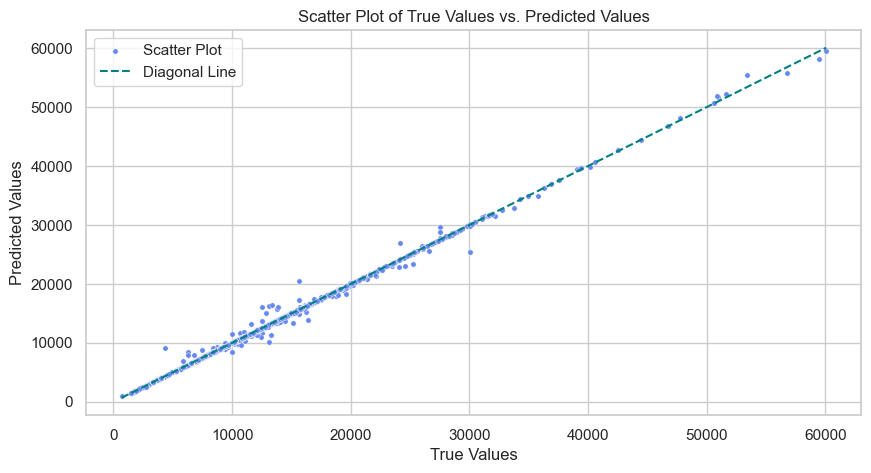

In [378]:
# Create a scatter plot
plt.figure(figsize=(10,5))
sns.scatterplot(data=model_result, x='actual', y='prediction',label='Scatter Plot', s=15)

# Plot diagonal lines
min_val = min(np.min(y_test), np.min(y_pred))
max_val = max(np.max(y_test), np.max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], '--', label='Diagonal Line', color="teal")

# Set axis labels and a legend
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()

# Show the plot
plt.title('Scatter Plot of True Values vs. Predicted Values')
plt.show()

In [365]:
grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('col_transformer',
                                        ColumnTransformer(transformers=[('robust',
                                                                         RobustScaler(),
                                                                         ['car_year',
                                                                          'car_engine_size',
                                                                          'buy_price',
                                                                          'admin_fee',
                                                                          'aging_fee',
                                                                          'date_diff']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['car_transmission'])])),
                                       ('random_forest',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'random_forest__bootstrap': [True, False],
                         'random_forest__max_depth': [None, 10, 20, 30],
                         'random_forest__min_samples_leaf': [1, 2, 4],
                         'random_forest__min_samples_split': [2, 5, 10],
                         'random_forest__n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [366]:
with open('./deployment/model/rf_tuned.pkl', 'wb') as file:
  pickle.dump(grid_search, file)

## 06. Inferencing

In [367]:
with open('./deployment/model/rf_tuned.pkl', 'rb') as file_1:
  model_load = pickle.load(file_1)

In [368]:
df[df['isTarget'] == 0].sample()

,product_id,license_plate,car_year,car_brand,car_model,car_type,car_transmission,car_engine_size,car_color,inspection_score,...,buy_date,buy_price,admin_fee,aging_fee,sell_date,sell_price,target_price,revenue_diff,isTarget,date_diff
1155,128832,2610,2017,NISSAN,GRAND LIVINA,SV,MT,1.5,Putih,107,...,2022-08-27,12788.0,250.0,500.0,2022-10-15,11850.0,13538.0,-1688.0,0,49


In [369]:
df_inf = [{   
    'car_year'          : 2013,
    'car_engine_size'   : 1.3,
    'car_transmission'  : 'MT',
    'buy_price'         : 13750.0,
    'admin_fee'         : 250.0,
    'aging_fee'         : 438.0,
    'date_diff'         : 44
    
}]

df_inf = pd.DataFrame(df_inf)

df_inf

,car_year,car_engine_size,car_transmission,buy_price,admin_fee,aging_fee,date_diff
0,2013,1.3,MT,13750.0,250.0,438.0,44


In [370]:
predict_inf = model_load.predict(df_inf)
target_price_inf = df_inf['buy_price'] + df_inf['admin_fee'] + df_inf['aging_fee']

price_diff_inf = round(((target_price_inf[0] - predict_inf[0]) / target_price_inf[0])*100,2)

if price_diff_inf > 10:
    car_label = "Poor Quality Buy"
    reasons = "Difference between predicted and target sale price is more than 10%"
else:
    car_label = "Worth To Buy"
    reasons = "Difference between predicted and target sale price is below 10%"

In [371]:
print("Car Quality Buy Prediction")
print(f"Car Target Price    : {target_price_inf[0]}")
print(f"Car Predicted Price : {predict_inf[0]}")
print(f"Price Diff Percentage : {price_diff_inf}%")
print(f"\nThis Car is {car_label}")
print(f"{reasons}")



Car Quality Buy Prediction
Car Target Price    : 14438.0
Car Predicted Price : 12728.85
Price Diff Percentage : 11.84%

This Car is Poor Quality Buy
Difference between predicted and target sale price is more than 10%
